## Исследование рейтинга компьютерных игр для интернет-магазина «Стримчик»

### Описание проекта
Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Не важно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».


### Шаг 1. Открытие файла и изучение общей информации.

In [285]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st
import pylab

In [286]:
games_data = pd.read_csv('/datasets/games.csv', sep=',')
display(games_data.head())
games_data.info()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


### Шаг 2. Подготовка данных.

Заменим названия столбцов (приведем к нижнему регистру)

In [287]:
games_data.columns = games_data.columns.str.lower()
display(games_data.columns)

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

Выясним количество и долю пропущенных значений в датасете.

In [288]:
display(games_data.isnull().sum())
display(games_data.isnull().sum() / len(games_data))

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

name               0.000120
platform           0.000000
year_of_release    0.016093
genre              0.000120
na_sales           0.000000
eu_sales           0.000000
jp_sales           0.000000
other_sales        0.000000
critic_score       0.513192
user_score         0.400897
rating             0.404786
dtype: float64

Значения пропущены в 5 столбцах. Возможные причины:
 - по некоторым играм нет точной информации по году выпуска. 
 - в категории жанр было представлено несколько значений, при подготовке данных их могли удалить при фильтрации. 
 - данные могли некорректно скопироваться
 - у половины игр нет в принципе информации по оценке критиков, оценке пользователей и рейтингу, т.к. какие-либо игры были выпущены при другой системе оценки/либо ее отсутствит, либо не были рассмотрены ни пользователями, ни критиками.


Удалим пропуски в двух столбцах: genre и year_of_release, т.к. их доля небольшая - 0,012% и 1,6% соответственно. Игры без даты выпуска и жанра нам неинтересны

In [289]:
games_data.dropna(subset = ['genre', 'year_of_release'], inplace = True) 
display(games_data.isnull().sum())

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         6605
rating             6676
dtype: int64

Почти у 40-50% данных не указаны оценки критиков и пользователей, а также рейтинг. Это слишком много для удаления. Заменим пропуски на ноль, возможно, пропуски вполне логичны в определенных периодах выпуска игр.

In [290]:
for column in ['critic_score', 'user_score', 'rating']:
    games_data[column] = games_data[column].fillna('0')
display(games_data.isnull().sum())
games_data.info()

name               0
platform           0
year_of_release    0
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score       0
user_score         0
rating             0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null float64
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       16444 non-null object
user_score         16444 non-null object
rating             16444 non-null object
dtypes: float64(5), object(6)
memory usage: 1.5+ MB


Преобразуем данные в нужные типы. 
Тип данных в столбце user_score необходимо изменить со строчного на вещественный. При преобразовании обнаружена аббревиатура 'tbd' - to be determined - будет определено позднее. Сначала замением ее на NaN, а затем на "ноль".

In [291]:
games_data['user_score'] = games_data['user_score'].replace('tbd', 'NaN')
games_data['user_score'] = games_data['user_score'].fillna('0')
games_data['user_score'] = games_data['user_score'].apply(float)
games_data['critic_score'] = games_data['critic_score'].apply(float)

Тип данных в столбце year_of_release необходимо изменить с вещественного числа на целое, т.к. год выражается только целыми числами.

In [292]:
games_data['year_of_release'] = games_data['year_of_release'].apply(int)
games_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null int64
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       16444 non-null float64
user_score         14068 non-null float64
rating             16444 non-null object
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


Создадим отдельный столбец с суммарными продажами во всех регионах 

In [293]:
games_data['turnover'] = games_data['na_sales'] + games_data['eu_sales'] + games_data['jp_sales'] + games_data['other_sales'] 
display(games_data.head())                                                                                                
                                                                                                               

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,turnover
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,0.0,0.0,0,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,0.0,0.0,0,31.38


### Шаг 3. Анализ данных

Проверим, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?
Построим график по году выпуска игры.
Данные за период 1980-1994 не очень важны, т.к. в год выпускалось всего 10-50 игр.
Основной рост количества выпускаемых игр произошел в 1995-2009 гг. Количество игр увеличилось в 7 раз за 14 лет. Возможно, это связано с популяризацией данного развлечения и увеличения игроков за счет как и снижения, так и повышения возрастного ценза.  
Согласно графику больше всего выпускалось игр в 2008-2009 гг. Далее начался спад, вероятно связанный с последствиями мирового кризиса 2008-2009 гг. Количество игр уменьшалось, и к в 2016 году было выпущено в 3 раза меньше игр (около 500), чем в пиковые 2008-2009. Хотя это достаточно высокая цифра, т.к. почти 1,4 количества новинок выходит ежедневно.

Text(0, 0.5, 'number of games')

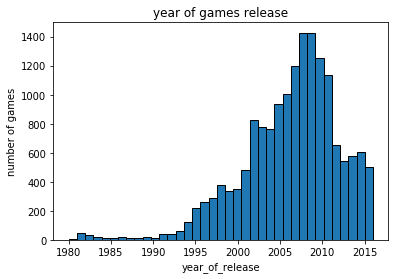

In [294]:
years = games_data["year_of_release"].max() - games_data["year_of_release"].min() + 1
plt.hist(games_data["year_of_release"], bins=years, edgecolor="black")
plt.title("year of games release")
plt.xlabel("year_of_release")
plt.ylabel("number of games")


In [295]:
top_platform = ['PS2', 'X360', 'PS3', 'Wii', 'DS']
top_platform_turnover = (games_data
    .query('platform in @top_platform')
    .pivot_table(index=['platform'], values= ['turnover'], aggfunc='sum')
    .sort_values(by= 'turnover', ascending=False)
    ) 
display(top_platform_turnover.head(5))

,turnover
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.78


Построим распределение оборота top-платформ по годам. Период 1980-1990 рассматривать не будем, т.к.развитие индустрии началось после 1990 г. (в 1994 году Sony выпустили самую первую Playstation), кроме того данные top-платформы начали запускаться только с 2000-хх.
Характерный срок для появления новых и исчезновения старых платформ - примерно 10 лет.
Поддержка всех top-платформ на данный момент прекращена.
Самая продаваемая PS2 выпускалась почти 13 лет (пик продаж - 250 млн.долларов), что является одним из самых долгих сроков для игровой индустрии. Производство было прекращено в 2013 году.
Чуть меньше достигала Wii - 230 млн.долларов в 2009 году.

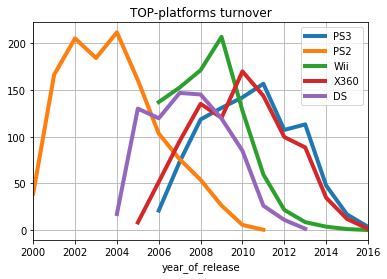

In [296]:
PS3 = ["PS3"]
ax = games_data.query('platform == @PS3 & year_of_release >= 1990').groupby('year_of_release')['turnover'].sum().plot(x='year_of_release', y='turnover', kind='line', label='PS3', linewidth=4, legend=True)
 
dict_platform = ["PS2", "Wii", "X360", "DS"]
for element in dict_platform:
    games_data.query('platform == @element & year_of_release >= 1990').groupby('year_of_release')['turnover'].sum().plot(x='year_of_release', y='turnover', kind='line', title='TOP-platforms turnover', ax=ax, label=element, linewidth=4, legend=True, grid=True)


Определим актуальный период для построения прогноза на 2017 год. По количеству игр, выпускаемых в посткризисный период, рынок стал расти после 2013 года, но по предварительным данным за 2016 г. снова понизилось количество игр до уровня 2000 г. При этом аналогичного роста, последовавшего за 2000 г., мы прогнозировать пока не можем, т.к. сейчас чаще выпускают обновленные версии уже популярных игр, которые точно можно продать. Возможно, осторожничают с новинками, которые пользователи могут не оценить и не купить.
Создадим выборку за период 2013-2016.

In [297]:
actual_period = games_data.query('year_of_release >= 2013')


In [298]:
actual_period.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2233 entries, 16 to 16714
Data columns (total 12 columns):
name               2233 non-null object
platform           2233 non-null object
year_of_release    2233 non-null int64
genre              2233 non-null object
na_sales           2233 non-null float64
eu_sales           2233 non-null float64
jp_sales           2233 non-null float64
other_sales        2233 non-null float64
critic_score       2233 non-null float64
user_score         2125 non-null float64
rating             2233 non-null object
turnover           2233 non-null float64
dtypes: float64(7), int64(1), object(4)
memory usage: 226.8+ KB


Определим, какие платформы лидируют по продажам в периоде 2013-2016.
Пятерка лидеров отличается от лидеров в рамках общей истории. 
Теперь это PS4 (c большим отрывом по обороту), XOne, 3DS - новые лидеры. PS3(поднялась на 2-е место), X360(переместилась на 5-е место).

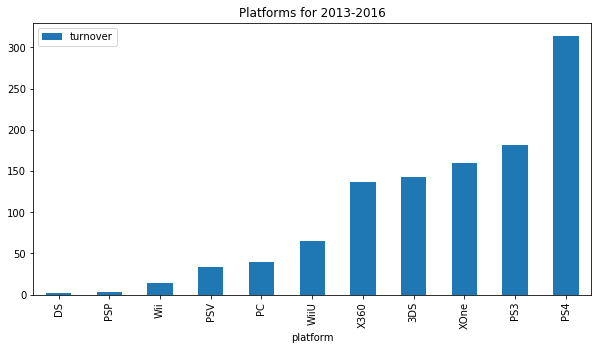

In [299]:
actual_period_pivot = actual_period.pivot_table(index="platform", values="turnover", aggfunc="sum")
actual_period_pivot.sort_values(by='turnover', ascending=True).plot(y='turnover', kind='bar',title='Platforms for 2013-2016', figsize=(10, 5))


Определим, какие платформы растут или падают в периоде 2013-2016.
Выберем несколько потенциально прибыльных платформ:
Как мы и выяснили на общем график продаж за всю историю, что предварительно 2016 год показывает спад, поэтому все платформы падают с 1-й половины 2015 года. Данные за 2016 год еще неполные - только за 1-е полугодие. Поэтому акцентируем внимание на кривую продаж с 2013 по 2015 год:
Wii, PSP - почти ноль продаж за данный период, т.к. поддержка прекращена в 2013 г.
PS3, X360, 3DS - стремительно падают с 2013 года, скорее всего их производство будет прекращено в ближайшее время или уже прекращено в 2016 г.
WiiU, PC, PSV,  не показали никакого роста за 3 года, более того с 2014 г.начался спад, но, возможно, данные платформы могут и далее также понемногу, но стабильно, приносить прибыль.
Таким образом, самыми перспективными для прибыли могут быть PS4 и XOne, которые также в лидерах по обороту за данный период. До 2015 г.обе платформы показывали хороший и стабильный рост, падение в 2015 году, может еще скорректироваться в 2-м полугодии 2016 г.

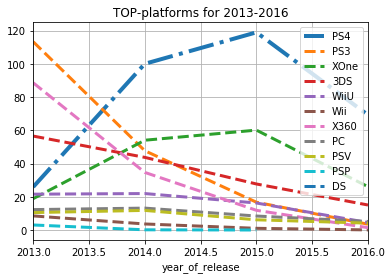

In [300]:
PS4 = ["PS4"]
ax = actual_period.query('platform == @PS4').groupby('year_of_release')['turnover'].sum().plot(x='year_of_release', y='turnover', kind='line', label='PS4', linewidth=4,  linestyle = '-.', legend=True)
 
actual_dict_platform = ["PS3", "XOne", "3DS", "WiiU", "Wii", "X360", "PC", "PSV", "PSP", "DS"]
for element in actual_dict_platform:
    actual_period.query('platform == @element').groupby('year_of_release')['turnover'].sum().plot(x='year_of_release', y='turnover', kind='line', title='TOP-platforms for 2013-2016', ax=ax, label=element, linewidth=3, linestyle = '--', legend=True, grid=True)


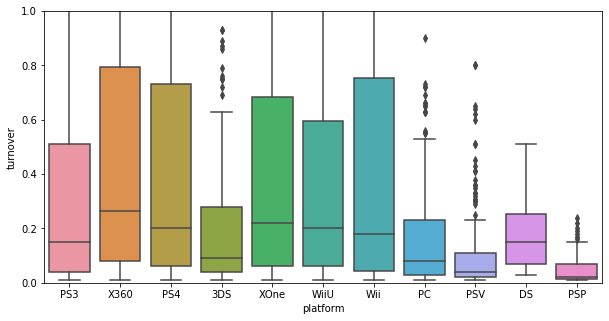

In [301]:

actual_sales = actual_period.platform.value_counts().sort_values(ascending = False).head(11).index.values
         
fig, ax = plt.subplots(figsize = (10, 5))  
sns.boxplot(x='platform', y='turnover', data=actual_period[actual_period.platform.isin(actual_sales)])
plt.ylim = 500
ax.set_ylim (0,1)
plt.show()


Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами (отдельно пользователей и отдельно критиков) и продажами на примере самой прибыльной платформы в 2013-2016 гг. - PS4. Предварительно удалим строки с нулевыми значениями в столбцах с отзывами и рейтингом в выбранном периоде и создадим отдельную выборку для расчета корреляции.
1. User Score: очевидно, что отзывы пользователей не влияют на продажи, т.к. большая часть продаж совсем без отзывов (около 60%). Другая часть сосредоточена на интервале оценок 5.7 - 8.3. При этом у топ-лидера по продажам нет максимальных 10-балльных оценок. Отрицательный коэффициент корреляции Пирсона -0.033 подтверждает, что зависимости почти нет.

In [349]:
for column in ['critic_score', 'user_score', 'rating']:
    period_notnull = period_notnull.loc[~period_notnull[column].isin([0.00])].dropna()
period_notnull.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 976 entries, 16 to 16692
Data columns (total 12 columns):
name               976 non-null object
platform           976 non-null object
year_of_release    976 non-null int64
genre              976 non-null object
na_sales           976 non-null float64
eu_sales           976 non-null float64
jp_sales           976 non-null float64
other_sales        976 non-null float64
critic_score       976 non-null float64
user_score         976 non-null float64
rating             976 non-null object
turnover           976 non-null float64
dtypes: float64(7), int64(1), object(4)
memory usage: 99.1+ KB


In [350]:
actual_period.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2233 entries, 16 to 16714
Data columns (total 12 columns):
name               2233 non-null object
platform           2233 non-null object
year_of_release    2233 non-null int64
genre              2233 non-null object
na_sales           2233 non-null float64
eu_sales           2233 non-null float64
jp_sales           2233 non-null float64
other_sales        2233 non-null float64
critic_score       2233 non-null float64
user_score         2125 non-null float64
rating             2233 non-null object
turnover           2233 non-null float64
dtypes: float64(7), int64(1), object(4)
memory usage: 226.8+ KB


-0.03362497596528878

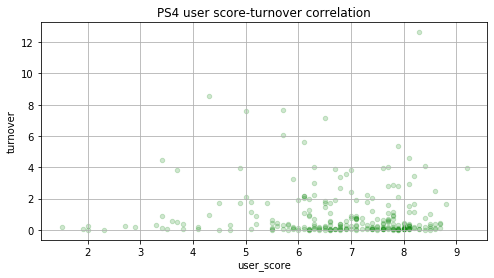

In [351]:
games_data.dropna(subset = ['genre', 'year_of_release'], inplace = True) 

user_score_pivot = period_notnull.query('platform == "PS4"').pivot_table(index="user_score", values="turnover", aggfunc="sum").sort_values(by='turnover', ascending = False)
period_notnull.query('platform == @PS4').plot(x='user_score', y='turnover', kind='scatter', color='green', title='PS4 user score-turnover correlation', figsize=(8,4), grid=True, alpha=0.19) 
display(period_notnull.query('platform == "PS4"')['user_score'].corr(period_notnull.query('platform == "PS4"')['turnover']))

2.Critic Score: Аналогичная ситуация с оценкой критиков. 100-балльных оценок нет. Больше половины продаж без оценки. Далее, идут продажи при оценке 83 балла. Достаточно много продаж при интервале 60-80 баллов. Коэффициент корреляции составляет 0.4, что говорит об очень  слабой зависимости продаж от оценки критиков.


0.40589480145836687

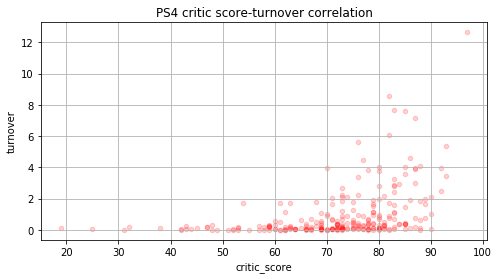

In [352]:
critic_score_pivot = period_notnull.query('platform == "PS4"').pivot_table(index="critic_score", values="turnover", aggfunc="sum").sort_values(by='turnover', ascending = False)
period_notnull.query('platform == @PS4').plot(x='critic_score', y='turnover', kind='scatter', color='red', title='PS4 critic score-turnover correlation', figsize=(8,4), grid=True, alpha=0.18) 
display(period_notnull.query('platform == "PS4"')['critic_score'].corr(period_notnull.query('platform == "PS4"')['turnover']))

Соотнесем данные выводы с продажами игр на других платформах с помощью корреляции. Также нет зависимости между оценкой пользователей и продажами,  коэффициент Пирсона тоже отрицательный   -0.004. Критики не сильно влияют на общие продажи по всем платформам, коэффициент 0.3 близок значению для платформы PS4.

In [353]:
period_notnull.corr()


,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,turnover
year_of_release,1.000000,-0.151237,-0.092214,-0.111958,-0.106078,0.062698,0.049488,-0.135866
na_sales,-0.151237,1.000000,0.723136,0.248775,0.795044,0.299088,-0.019770,0.910940
eu_sales,-0.092214,0.723136,1.000000,0.278349,0.931017,0.279212,-0.031245,0.933210
jp_sales,-0.111958,0.248775,0.278349,1.000000,0.272122,0.131863,0.193623,0.379603
other_sales,-0.106078,0.795044,0.931017,0.272122,1.000000,0.273573,-0.011071,0.944049
critic_score,0.062698,0.299088,0.279212,0.131863,0.273573,1.000000,0.502221,0.311692
user_score,0.049488,-0.019770,-0.031245,0.193623,-0.011071,0.502221,1.000000,-0.004064
turnover,-0.135866,0.910940,0.933210,0.379603,0.944049,0.311692,-0.004064,1.000000


Посмотрим на общее распределение игр по жанрам. 


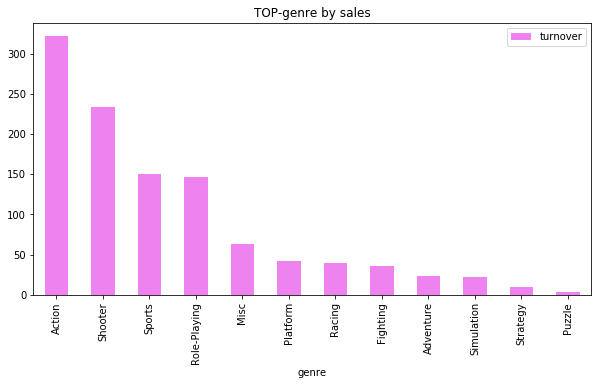

In [354]:
genre_sales = actual_period.pivot_table(index="genre", values="turnover", aggfunc="sum").sort_values(by='turnover', ascending = False)
#display(genre_sales)
genre_sales.plot(y='turnover', kind='bar', color='violet', title='TOP-genre by sales', figsize=(10, 5))


Самые прибыльные жанры c оборотом в диапазоне 140-350 млн.долларов - Action, Shooter, Sports, Role-playing идут с большим отрывом по продажам. Низкие продажи от 10 до 60 млн.долларов у Platform, Racing, Fighting, Adventure, Simulation, Strategy, Puzzle.
Объем продаж Action в 30 раз выше объема продаж Puzzle (жанр с самыми низкими продажами).

### Шаг 4. Составление портрета пользователя каждого региона

Определим для пользователя каждого региона (NA, EU, JP):
1. Самые популярные платформы (топ-5) распределяются по регионам следующим образом:
Для региона NA: PS4, XOne, X360, PS3,  3DS
Для региона EU: PS4, PS3,  XOne, X360, 3DS
Для региона JP: 3DS, PS3,  PSV,  PS4,  WiiU
В NA и EU одни и те же лидеры, только 2-4 позиции меняются местами.
В JP две платформы - WiiU и PSV - не относятся к глобальным лидерам, и последняя TOP-5 в Европе и Америке платформа 3DS здесь абсолютный лидер.

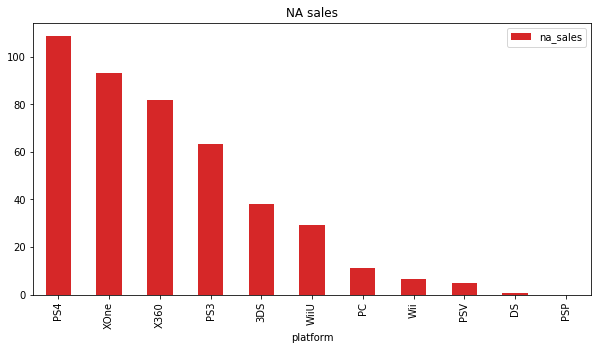

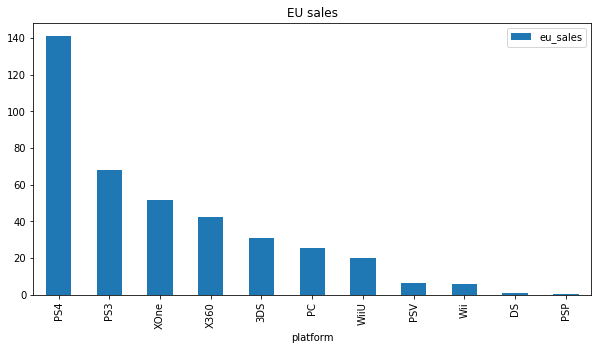

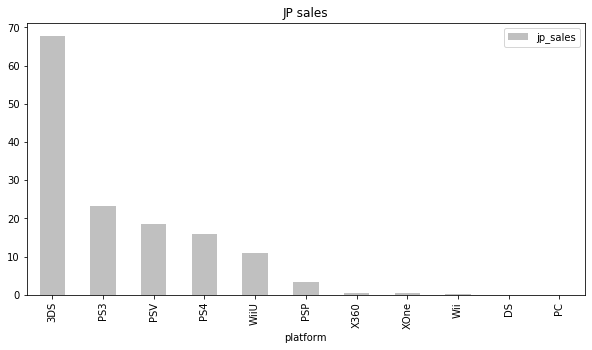

In [355]:
NA_sales = actual_period.pivot_table(index="platform", values="na_sales", aggfunc="sum").sort_values(by='na_sales', ascending=False).plot(y='na_sales', kind='bar',title='NA sales', color='tab:red', figsize=(10, 5))
EU_sales = actual_period.pivot_table(index="platform", values="eu_sales", aggfunc="sum").sort_values(by='eu_sales', ascending=False).plot(y='eu_sales', kind='bar',title='EU sales', color='tab:blue', figsize=(10, 5))
JP_sales = actual_period.pivot_table(index="platform", values="jp_sales", aggfunc="sum").sort_values(by='jp_sales', ascending=False).plot(y='jp_sales', kind='bar',title='JP sales', color='silver', figsize=(10, 5))



Рассмотрим доли продаж по регионам у всех платформ. PS4, PS3 имеют больший объем продаж в Европе, хотя в Сев.Америке PS4 также лидер №1. Продажи XOne, X360 удачнее продаются  в Северной Америке. 3DS, PSV - в Японии, а PC и DS там совсем не продаются.

In [356]:
sales_share = actual_period.pivot_table(index='platform', values={"na_sales", "eu_sales", "jp_sales"}, aggfunc="sum").sort_values(by='na_sales', ascending=False).head(11)
display(sales_share)

,eu_sales,jp_sales,na_sales
platform,,,
PS4,141.09,15.96,108.74
XOne,51.59,0.34,93.12
X360,42.52,0.51,81.66
PS3,67.81,23.35,63.50
3DS,30.96,67.81,38.20
WiiU,19.85,10.88,29.21
PC,25.36,0.00,11.11
Wii,5.93,0.05,6.56
PSV,6.10,18.59,5.04


Для наглядности проверим платформы-лидеры на доли продаж по регионам: PS4, PS3 - 53% и 44% приносит европейский рынок соответственно.
XOne 64% приносит Сев.Америка. Платформе 3DS японский рынок дает почти половину всех продаж - 49.6%.

Text(0.5, 1.0, 'PS4 Regional Sales')

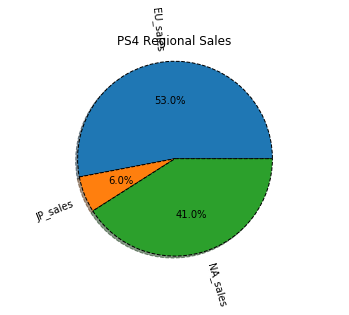

In [357]:
sales_PS4 = actual_period.query('platform == "PS4"').pivot_table(index='platform', values={"na_sales", "eu_sales", "jp_sales"}, aggfunc="sum")
#display(sales_PS4)

vals = [141, 16, 109]
labels = ["EU_sales", "JP_sales", "NA_sales"]
fig, ax = plt.subplots()
ax.pie(vals, labels=labels, autopct='%1.1f%%', shadow=True, wedgeprops={'lw':1, 'ls':'--','edgecolor':"k"}, rotatelabels=True)
ax.axis("equal")
plt.title('PS4 Regional Sales')

Text(0.5, 1.0, 'PS3 Regional Sales')

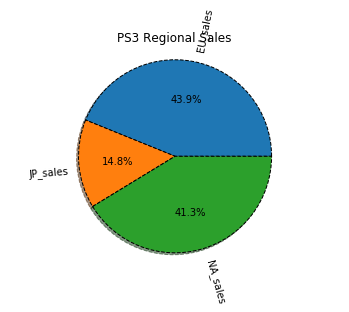

In [330]:
sales_PS3 = actual_period.query('platform == "PS3"').pivot_table(index='platform', values={"na_sales", "eu_sales", "jp_sales"}, aggfunc="sum")

vals = [68, 23, 64]
labels = ["EU_sales", "JP_sales", "NA_sales"]
fig, ax = plt.subplots()
ax.pie(vals, labels=labels, autopct='%1.1f%%', shadow=True, wedgeprops={'lw':1, 'ls':'--','edgecolor':"k"}, rotatelabels=True)
ax.axis("equal")
plt.title('PS3 Regional Sales')

Text(0.5, 1.0, 'XOne Regional Sales')

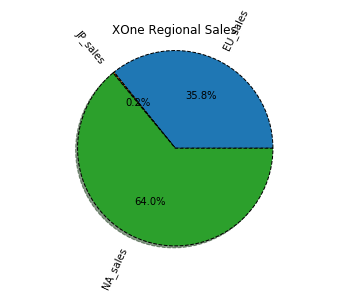

In [331]:
sales_XOne = actual_period.query('platform == "XOne"').pivot_table(index='platform', values={"na_sales", "eu_sales", "jp_sales"}, aggfunc="sum")

vals = [52, 0.3, 93]
labels = ["EU_sales", "JP_sales", "NA_sales"]
fig, ax = plt.subplots()
ax.pie(vals, labels=labels, autopct='%1.1f%%', shadow=True, wedgeprops={'lw':1, 'ls':'--','edgecolor':"k"}, rotatelabels=True)
ax.axis("equal")
plt.title('XOne Regional Sales')

Text(0.5, 1.0, '3DS Regional Sales')

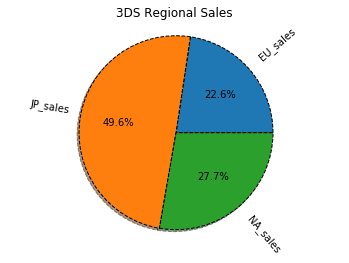

In [332]:
sales_3DS = actual_period.query('platform == "3DS"').pivot_table(index='platform', values={"na_sales", "eu_sales", "jp_sales"}, aggfunc="sum")

vals = [31, 68, 38]
labels = ["EU_sales", "JP_sales", "NA_sales"]
fig, ax = plt.subplots()
ax.pie(vals, labels=labels, autopct='%1.1f%%', shadow=True, wedgeprops={'lw':1, 'ls':'--','edgecolor':"k"}, rotatelabels=True)
ax.axis("equal")
plt.title('3DS Regional Sales')

2.Самые популярные жанры (топ-5) по регионам.
Поскольку 70% игр на каждой платформе включают все жанры, мы не можем сказать, что жанровое предпочтение и предпочтение платформ связаны между собой. Хотя мы видим, что популярные для Запада платформы не очень интересны для японских пользователей, возможно, они производят только продукцию, ориентированную на Запад.  Это подтверждается тем, что многие изначально японские компании перенесли свои штаб-квартиры в Европу и Америку. Японские разработчики стараются заинтересовать пользователей из других стран, локализируя свои продукты, но для внутреннего рынка Японии существует другой тренд - сохранение культурной идентичности в играх и делать то, на что способны только японцы.
Возможно, разница в предпочтении жанров, связана с межкультурными различиями:
- в Европе и Сев.Америке превалирует западная культура, поэтому топ-5 жанров практически идентичны;
- за исключением Racing в Америке (возможно, из-за популярности игр, которые легко освоить, плюс эффект конкуренции, неотъемлимой части культуры США); 
- а также Fighting в Европе (может быть, из-за предпочтения игр с военными сражениями, плюс коллективного участия и такой культурной ценности как интеграция);
- в Японии пользователи любят играть в Platformer и Simulation, более предназначенные для одного человека, воплощения его фантазий или испытания его возможностей, которые не всегда реальны в очень традиционном и иерархическом обществе;
- также важен способ игры - Platformer практически не требуют какого-либо высокотехничного игрового оборудования, японцам достаточно смартфона или ноутбука, и это частое явление, особенно в метро. 
- одно из главных отличий: на Западе стремятся к наиболее реалистичному изображению и воплощению в играх, в Японии, наоборот, чем нереальнее, фантастичнее и непонятнее, тем привлекательней для пользователей будет игра. Поэтому для японских игр очень важен сюжет, а для западных - спецэффекты, технологические новинки и сверхвозможности героев.


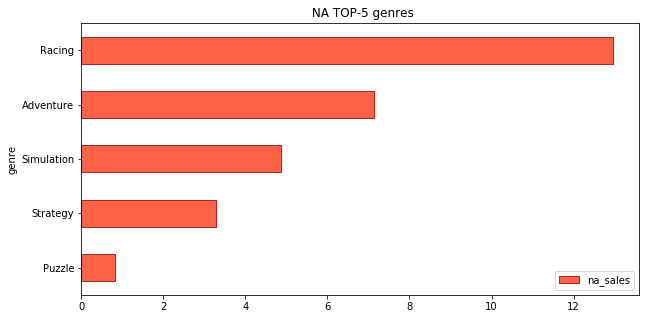

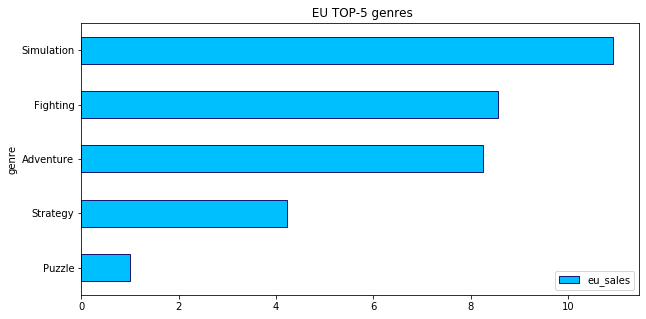

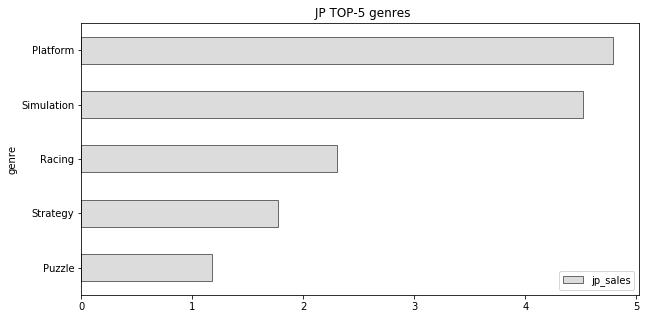

In [358]:
NA_top_genres = actual_period.pivot_table(index="genre", values="na_sales", aggfunc="sum").sort_values(by='na_sales', ascending = True).head()
NA_top_genres.plot(y='na_sales', kind='barh', color='tomato', edgecolor="brown", title=' NA TOP-5 genres', figsize=(10, 5))

EU_top_genres = actual_period.pivot_table(index="genre", values="eu_sales", aggfunc="sum").sort_values(by='eu_sales', ascending = True).head()
EU_top_genres.plot(y='eu_sales', kind='barh', color='deepskyblue', edgecolor="midnightblue", title=' EU TOP-5 genres', figsize=(10, 5))

JP_top_genres = actual_period.pivot_table(index="genre", values="jp_sales", aggfunc="sum").sort_values(by='jp_sales', ascending = True).head()
JP_top_genres.plot(y='jp_sales', kind='barh', color='gainsboro', edgecolor="dimgrey", title=' JP TOP-5 genres', figsize=(10, 5))



# 3. Проверим, влияет ли рейтинг ESRB на продажи в отдельном регионе. 
На глобальном уровне, учитывая, что 40% игра без рейтинга, думаю, что он все-таки влияет на продажи. Построим графики на выборке без нулевых рейтингов. Самые продаваемые игры с рейтингом М "Для взрослых", а самая менее продаваемая категория - E10 "Для всех старше 10 лет". У взрослых больше финансовых возможностей и,наверное, игры в этой категории наиболее интересные. В среднем продаются Е и T игры - для всех и для подростков.


,eu_sales,jp_sales,na_sales
rating,,,
M,135.48,12.93,152.83
E,69.18,14.14,65.67
T,38.87,16.54,45.13
E10+,29.97,5.65,39.01
0,2.07,0.23,1.06


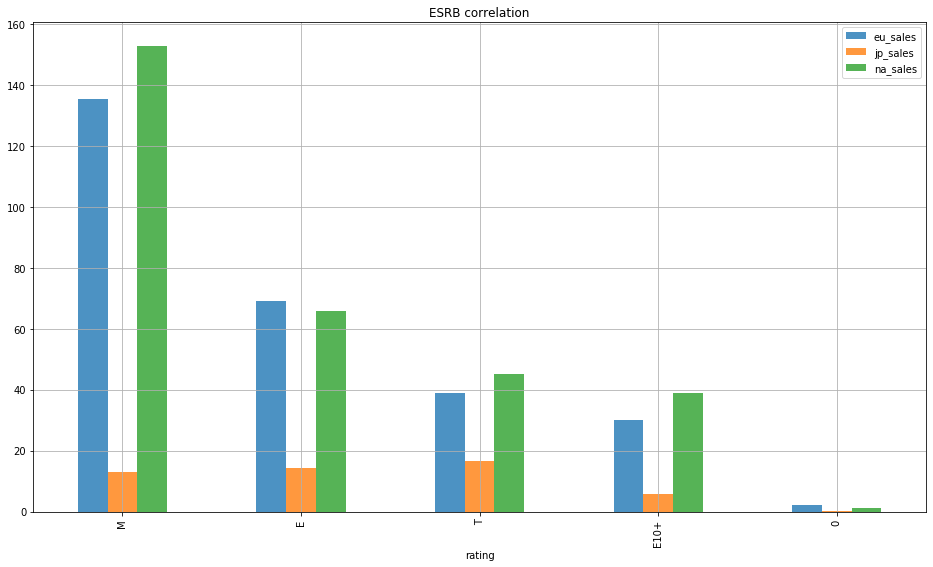

In [359]:
ESRB = period_notnull.pivot_table(index="rating", values={"na_sales", "eu_sales", "jp_sales"}, aggfunc="sum").sort_values(by='na_sales', ascending = False)
display(ESRB)
ESRB.plot(kind='bar', title='ESRB correlation', figsize=(16,9), grid=True, alpha=0.8) 


В Сев.Америке чем выше возрастной рейтинг, тем выше продажи. Коэффициент 0.61 указывает на среднюю корреляцию. 

,eu_sales,jp_sales,na_sales,rnumber
rating,,,,
M,135.48,12.93,152.83,4
E,69.18,14.14,65.67,0
T,38.87,16.54,45.13,3
E10+,29.97,5.65,39.01,2
0,2.07,0.23,1.06,1


0.6108377377689468

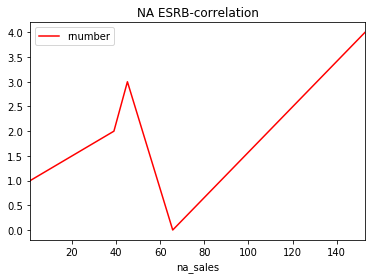

In [360]:
ESRB['rnumber'] = [4, 0, 3, 2, 1]
display(ESRB)
ESRB.plot(x='na_sales', y='rnumber', kind='line', color='red', title='NA ESRB-correlation', alpha = 1)
display(ESRB['rnumber'].corr(ESRB['na_sales']))


В Европе такая же ситуация - самые большие продажи у рейтинга М. Коэффициент средней корреляции 0.52

0.526140227846602

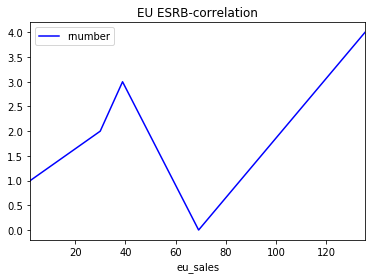

In [361]:
ESRB.plot(x='eu_sales', y='rnumber', kind='line', color='blue', title='EU ESRB-correlation', alpha = 1)
display(ESRB['rnumber'].corr(ESRB['eu_sales']))


В Японии рейтинг либо не влияет на продажи, возможно, в этой стране другая система рейтинга (например, CERO). Либо нет прямой зависимости. Наблюдается слабая корреляция 0.32. Лучше всего игры Т(подростковые), далее - Е(для всех), в отличие от западных предпочтений, игры М (для взрослых) почти на последнем месте.


0.3248560887134272

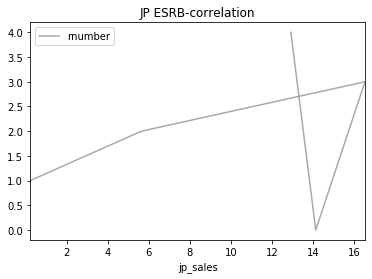

In [363]:
ESRB.plot(x='jp_sales', y='rnumber', kind='line', color='darkgrey', title='JP ESRB-correlation', alpha = 1)
display(ESRB['rnumber'].corr(ESRB['jp_sales']))


#### Вывод
- Пользователи Северной Америки предпочитают: платформы PS4, XOne, X360, PS3, 3DS; жанры Racing, Adventure, Simulation, Strategy, Puzzle. Популярны игры, которые легко освоить и в которых присутствует конкуренция. Возможно, самые высокотехнологичные пользователи с возможностью оснащения всеми видами игровых устройств.

- Пользователи Европы выбирают примерно те же PS4, PS3, XOne, X360, 3DS; жанры Simulation, Fighting, Adventure, Strategy, Puzzle. Игроков привлекают военные сражения и коллективность в играх.

- У пользователей Японии другие топ-5 лидеры: 3DS, PS3, PSV, PS4, WiiU; жанры Platformer, Simulation, Racing, Strategy, Puzzle. Это игроки-одиночки в нереальном, непонятном мире фантазий, где очень важен сюжет, поэтому нет особой потребности к способу игры - приоритетнее доступность в любых локациях, не обязательно в оборудованной комнате геймера.

В целом, вырисовываются 2 вида ориентации на пользователей: западная и японская.


### Шаг 5. Проверка гипотез


#### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые


Нам нужно сгруппировать две совокупности согласно названию платформы: данные по средним пользовательским рейтингам платформы Xbox One и данные по средним пользовательским рейтингам платформы PC без нулевых значений в рейтингах. 
Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, нужно понять, нормально ли распределено выборочное вокруг среднего всей генеральной совокупности, значима ли разница между этими средними. Создадим выборки, вычислим их среднее и проверим нормальное распределение.

In [373]:
XOne_user_score = period_notnull.query('platform == "XOne"')['user_score']
PC_user_score = period_notnull.query('platform == "PC"')['user_score']

display(XOne_user_score.mean())
display(PC_user_score.mean())


6.538181818181818

6.3020270270270276

Задаем нормальное распределение с математическим ожиданием 6.41
и стандартным отклонением 0.13

In [386]:
distr = st.norm(6.41, 0.13) 
x = 6.41
result = distr.cdf(x) 
display(result)


0.5

Согласно результату вероятность получить 6.3 или меньше/больше при таком распределении равна 50%.

Для проверки этого проведем статистический тест с помощью метода scipy.stats.ttest_ind.
Проверим гипотезу, что средние пользовательские рейтинги обеих платформ равны. 
Формируем нулевую гипотезу: H₀ = "средний пользовательский рейтинг платформы Xbox One равен среднему пользовательскому рейтингу платформы PC". 

Из H₀ формулируем альтернативную гипотезу: H₁ = "средний пользовательский рейтинг платформы Xbox One не равен среднему пользовательскому рейтингу платформы PC". Уровень статистической значимости установим 2,5%. Есть основание полагать, что дисперсия выборок равна, поэтому установим параметр equal_var=True.

##### Не получилось отвергнуть нулевую гипотезу (p-value = 0.17), и мы предполагаем, что средние  пользовательские рейтинги платформ Xbox One  и PC равны.

In [378]:

alpha = .025
    
results = st.ttest_ind(
    XOne_user_score, 
    PC_user_score,
    equal_var=True)
    
print('p-значение: ', results.pvalue)
    
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")


p-значение:  0.17306926618147322
Не получилось отвергнуть нулевую гипотезу


#### Средние пользовательские рейтинги жанров Action  и Sports разные.

Нам нужно сгруппировать две совокупности согласно названию жанра: данные по средним пользовательским рейтингам жанра Action и данные по средним пользовательским рейтингам жанра Sports без нулевых значений в рейтингах.Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, нужно понять, нормально ли распределено выборочное вокруг среднего всей генеральной совокупности, значима ли разница между этими средними.

Вычислим среднее выборок по жанру.

In [379]:
Action_user_score = period_notnull.query('genre == "Action"')['user_score']
Sports_user_score = period_notnull.query('genre == "Sports"')['user_score']

display(Action_user_score.mean())
display(Sports_user_score.mean())

6.9362459546925574

5.665454545454545

Выясним, какова вероятность попасть в интервал 5.76 - 6.94 с математическим ожиданием 6.35 и стандартным отклонением 0.59

In [385]:
distr = st.norm(6.35, 0.59) 

x1 = 5.76
x2 = 6.94

result = distr.cdf(x2) - distr.cdf(x1)
display(result)


0.6826894921370862

Вероятность составляет 68%

Для определения равенства/неравенства выборок проведем статистический тест с помощью метода scipy.stats.ttest_ind.

Проверим гипотезу, что средние пользовательские рейтинги жанров Action и Sports равны. Формируем нулевую гипотезу: H₀ = "средний пользовательский рейтинг жанра Action равен среднему пользовательскому рейтингу жанра Sports". Из H₀ формулируем альтернативную гипотезу: H₁ = "средний пользовательский рейтинг жанра Action не равен среднему пользовательскому рейтингу жанра Sports". Уровень статистической значимости установим 2,5%.

##### Отвергаем нулевую гипотезу (p-value = 1.05) и мы предполагаем, что средние  пользовательские рейтинги жанров Action и Sports не равны.

In [384]:
alpha = .025
    
results = st.ttest_ind(
    Action_user_score, 
    Sports_user_score,
    equal_var=False)
    
print('p-значение: ', results.pvalue)
    
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")


p-значение:  1.0496920005008588e-13
Отвергаем нулевую гипотезу


### Вывод
